### Deep Learning Supervised Text Classification
- BiLSTM (no data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [1]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [4]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

### Load Data

In [5]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2209031206', # line strike
    '2210031122'  # site compliance or practice issue
]

In [7]:
# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: site compliance or practice issue


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [11]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

In [12]:
base_train_count = len(X_train)
base_train_count

75085

In [13]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 80 [38, 58, 764, 869, 881, 979, 2713, 3236, 3892, 4560, 4597, 4956, 5033, 5142, 5173, 5743, 5785, 6463, 6840, 6937, 7111, 7872, 8332, 8510, 8771, 8802, 9240, 9785, 10031, 10056, 10188, 10651, 10698, 10806, 10811, 10914, 11185, 11276, 12310, 12717, 12802, 13635, 13874, 15614, 16266, 17244, 19037, 19039, 20122, 20554, 20848, 22234, 22442, 22527, 22903, 23763, 25447, 26269, 30958, 33059, 39112, 39728, 39804, 41060, 45036, 45626, 48489, 52651, 54720, 62584, 62644, 65901, 69165, 79333, 81019, 86799, 86934, 87495, 91534, 93367]
Train: 320 [13, 20, 168, 370, 372, 507, 585, 606, 664, 710, 844, 925, 949, 1007, 1071, 1143, 1243, 1323, 1350, 1440, 1584, 1604, 1754, 1804, 1816, 1825, 1903, 1936, 2081, 2088, 2143, 2190, 2226, 2320, 2338, 2381, 2382, 2388, 2522, 2559, 2610, 2808, 2935, 3262, 3332, 3480, 3564, 3785, 3820, 4316, 4349, 4545, 4608, 4718, 4739, 5075, 5172, 5295, 5344, 5359, 5467, 5517, 5620, 5704, 5801, 5862, 5977, 6105, 6186, 6340, 6352, 6367, 6457, 6742, 6845, 6886, 7056, 7228, 7

In [14]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv(f'01_data/prepared/df_train_trues_{focus_cat}.csv')
df_train_trues

,text,category
13,preventable company vehicle incident life savi...,1
20,approximately fifteen litres of sewage overflo...,1
168,lifting coordinator lc preparing to perform a ...,1
370,tm crossed outer ndt exclusion zone barricade ...,1
372,unsafe act individual knowingly crossed a barr...,1
...,...,...
87997,other fall to lower level more than thirty fee...,1
88783,other fall to lower level six to ten feet whil...,1
90941,other fall to lower level six to ten feet an e...,1
91446,other fall to lower level sixteen to twenty fe...,1


## Build Model

In [15]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [16]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [17]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy', #'BinaryCrossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [18]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [19]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 58897
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           2944900   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [20]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'plant overhead crane made contact with wood broderson boom around two thousand, three hundred and thirty hours the plant subcontractor was moving the overhead crane south over the unit four crane bay wood broderson was set up over the unit four crane bay and was unoccupied and on standby the plant overhead crane operated by plant subcontractor made contact with the broderson boom the wood operator was not present in the cab of the broderson at the time of contact detailed description wood employees were told that they were going to have to move the broderson in order for a plant subcontractor to relocate the stator cover of the generator to the northeast corner of unit four turbine at approximately two thousand, one hundred at that point the wood operator and the employees working in the area were told that they did not need to move the broderson only to retract the boom and boom down which was completed prior to two thousand, one hundred once the piece had been flown around the south

### Model Training & Evaluatrion

In [21]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [22]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 288
Number of positives in validation data: 32


In [ ]:
# Train the model

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=3,
                              batch_size=128,
                              verbose=1)

Epoch 1/3
122/528 [=====>........................] - ETA: 19:50 - loss: 0.0595 - categorical_accuracy: 0.9924

In [ ]:
print(f'\nTotal training took {format_time(time.time()-total_t0)}')

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# load the model from disk
#fname = '2209181545_hydraulic fluid or oil leak_bilstm_model'
#filename = f'output/models/{fname}.pkl'
#model = pickle.load(open(filename, 'rb'))

In [21]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.52      0.88      0.65       107

    accuracy                           0.99     18772
   macro avg       0.76      0.94      0.83     18772
weighted avg       1.00      0.99      1.00     18772





In [22]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [23]:
Counter(y_test)

Counter({0: 18665, 1: 107})

In [24]:
# Check a random selection of 'trues', i.e., rule-book hits...
# These should be consistent with the focis category, e.g., hydraulic fluid
table = tmp[(tmp['rule_book']==1)].sample(20)
display(HTML(table.to_html()))

,text,pred,rule_book
20094,"a rack hoe had a hydraulic hose failure causing hydraulic fuild to leak on two thousand, four hundred and twenty-one two wood employee were working in the transformer laydown yard doing some demoing when the operator of the track hoe was extending out the boom to start working he and his spotter notice at the same time that one of the hydraulic hose had a small leak at the end of the boom the two employees shut down the job and notified operations frontline supervision safety and p66 contact all company and site protocols were followed actualpotential was based on minimal spill and minimal environmental impact employee stopped immediately and contacted supervisor and safety company portocol followed",1,1
1750,"excavator encountered a hydraulic hose failure within the engine housing area incident 38462the excavator driver was in the process of demolishing the canopy roof reinforcing bars at approximately two thousand, two hundred hrs the driver rotated his cab and tracked back to the standing position where he stopped and shutdown the excavator and climbed down from the cab and went round to where the engine housing door was locatedon further investigationit was identified that some oil had leaked from the engine housing onto the tracks it was apparent then that there had been a hydraulic hose failure in the engine housingimmediate corrective actions the rest of the work party were instructed to immediately spread absorbent granules on the track mat the driver was theninstructedto contact the service engineer to mobilise to site to replace the hose thecontrol room was contacted along with thearea authority on what had happenedfollow up actions the engineer surveyed the engine housing hoses but could not identify which hose was burst so he requested the driver to turn over the engine at low revs to pinpoint which hose had failed no further spillage occurred during this operation all that was visible was a fine mist contained in the engine housing he sourced the failed hose and the engine was shut down the engineer proceeded to remove the damaged hose and assembled a new one and added a protective shroud to eliminate chaffing of the new hose the new hose was fitted and tested and no further leaks were found see detailed description",1,1
1965,"post incident investigation reclassification approximately four thousand and fifty litres of morlina oil was spilled during decanting process see detailed description for updated information incident 38247on 21st june two thousand and eighteen at around eight hundred and thirty hours a wood general assistant ga was asked by a wood mechanical technician mt to set up a two hundred and five litre drum of morlina oil so that it could be decanted into smaller twenty litre containers at approx one thousand, one hundred and thirty hours the ga positioned the drum on top of five vertically stacked wooden pallets approx 75cm from the ground and searched for the mt to come and undertake the task by one thousand, four hundred hours and with the ga being unable to contact the mt the ga decided to carry out the task alone in doing so he began decanting the morlina oil utilising gravity by positioning and angling the drum so facilitating easier oil flow through a funnel into a smaller container when there was approximately four thousand and fifty litres of morlina oil left in the drum the ga discovered that the oil appeared too thick to continue draining with just gravity in an attempt to force the remaining oil out of the drum the ga decided to connect a pressurised airline to the drum using the plant air system which is accessed approximately fifteen yards from the chemical laydown yard plant air pressure is approximately seven barafter turning on the plant air the ga reentered the chemical laydown yard area and observed that the oil drum was visibly bulging he rushed back to turn off the air supply at which point there was a loud bang the lid of the drum parted from the main

In [25]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus}_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book
12085,a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead spill kits were immediately deployed and the spill was contained on the track near where the welfare unit was located a large plant nappy was also positioned under the welfare units generator and fuel tank the contaminated material from the track was placed on visqueen and will be up lifted and disposed of in line with good environmental practiceno water courses were affected by this incident,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
3677,"adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground incident 34452wpa angore yard adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground the adt was refuelled at 6am this morning approx 40l the adt was parked up in wpa yard and not working where wpa yard what 05lt of diesel to grade when 23th august one thousand, five hundred hrs how fuel tank was over filled which facilitated expansion to occur other refuellers observed spill and cleaned up the machine and contaminated soil further actions refuelling team was stood down and spoke to on importance of not overfilling equipment see detailed description",1,0
51918,contact with hot objects or substances an employee was transporting hot oil in a waste container by hand to a waste bin outside when the hot oil spilled onto the employee torso arms and legs causing burns that required hospitalization,1,0
12344,while performing chemical cleaning a spill occurred while preparing the replacement transport of the pump used for chemical cleaning the tankcontainer was overfilled the tankcontainer was overfilled due to a not properly closed valve altena assumed the valve was closed while it was not the case therefore the cleaning product continued to fill the container the tankcontainer caused back flow to one isocontainer from psa system approximately 1m3 was spilled into the containment berm the fire guard present decided to dilute the spill by water the containment berm was overfilled due to this and reached the sewer of the psa this sewer is not live yet hci industrial cleaning company was two hundred and forty-seven standby during this operation hci removed the spillage immediately by cleaning the sewers and area hci transferred this residue to designated baker tanks name,1,0
15924,h2s hydrogen sulfide gas leak twenty twenty workers were waiting to start work on the 6th floor of the coker plant before starting work the hse supervisor reviewed the levels of hydrogen sulfide gas in the working area the levels increased from six to nine ppm and hydrogen sulfide gas was coming from a line of steam according to indication from pemex operations the hse supervisor evacuated all personnel from the area at 11am pemex personnel controlled the leak all work in that area was suspended until the next day all staff was evacuated from the area activities were suspended and an official letter was delivered to the client requesting the inspection of their facilities additionally an hse specialist will visit the facility to inspect possible leakage in the coker plant,1,0
11203,"uxo found while doing road grading by fdh uxo found while doing road grading in fdh laydown area one 28o fifty-eig

In [26]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus}_fns.csv', index=False)
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')


There are 87 entries (out of 107)...

Total no. of positive predictions is  181...

Total no. of positive hits is  94...


,text,pred,rule_book
1965,"post incident investigation reclassification approximately four thousand and fifty litres of morlina oil was spilled during decanting process see detailed description for updated information incident 38247on 21st june two thousand and eighteen at around eight hundred and thirty hours a wood general assistant ga was asked by a wood mechanical technician mt to set up a two hundred and five litre drum of morlina oil so that it could be decanted into smaller twenty litre containers at approx one thousand, one hundred and thirty hours the ga positioned the drum on top of five vertically stacked wooden pallets approx 75cm from the ground and searched for the mt to come and undertake the task by one thousand, four hundred hours and with the ga being unable to contact the mt the ga decided to carry out the task alone in doing so he began decanting the morlina oil utilising gravity by positioning and angling the drum so facilitating easier oil flow through a funnel into a smaller container when there was approximately four thousand and fifty litres of morlina oil left in the drum the ga discovered that the oil appeared too thick to continue draining with just gravity in an attempt to force the remaining oil out of the drum the ga decided to connect a pressurised airline to the drum using the plant air system which is accessed approximately fifteen yards from the chemical laydown yard plant air pressure is approximately seven barafter turning on the plant air the ga reentered the chemical laydown yard area and observed that the oil drum was visibly bulging he rushed back to turn off the air supply at which point there was a loud bang the lid of the drum parted from the main body of the drum causing the remaining four thousand and fifty litres of morlina oil to escape and be sprayed over the chemical laydown yard the 400g air hose assembly fitting was discovered to have broken off and ejected from the drum the incident occurred at approximately one thousand, five hundred hours with the ga not in the immediate vicinity at the time there were no injuries to personnel an observation card was completed citing this as an oil leak the ga immediately began spill response alone using sobo cleaner and a fire hose to wash the spilled oil into the recognised bunded area oil drains system on hearing the bang the on duty process supervisor and members of the operations team searched for the source of the noise upon finding the employee in the chemical laydown yard they were informed that the oil drum had rolled off the pallet this was broadly accepted as there were high winds present on the day and the process team had a sense of relief that this noise had not emanated from a process safety related incident on friday 22nd june the mechanical supervisor ms visited the chemical laydown yard where it became apparent that there was more to the reported incident than first communicated as there was visible evidence of morlina oil on the walls and surrounding units of the chemical laydown yard on monday 25th june the site hse advisor asked the ga for a full statement of the event at which point it was first mentioned that pressurised air had been used this update was communicated back to sir ian wood house where upon a terms of reference tor was developed and issued with a formal investigation initiated shortly afterwards see detailed description",0,1
2867,operator was performing excavations for new pump separator foundations in the process of performing such task operator struck a four fiberglass line with backhoe rear bucket causing damage to line incident 36335morning meeting took place bjsa were put in place crews broke off and bjsa were further reviewed individually and thoroughly by crews stop work authority was covered hazards were identified mitigations were reviewed along with last minute risk assessments and assurance of one call being in place backhoe operator and spotter proceeded to perform task previously reviewed i


There are 13 entries (out of 107, 12.1%)...


### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


### Save Model to Local Drive

In [27]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus}_bilstm_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
len(X_train)

75085

In [ ]:
len(y_train)

75085

In [ ]:
# Reduce majority class to be X% of the majority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_Glove_us, y_train_us = pipeline.fit_resample(X_train_Glove, y_train)

In [ ]:
len(X_train_Glove_us)

1410

In [ ]:
counter = Counter(y_train_us)
print(counter)

Counter({0: 940, 1: 470})


In [ ]:
history_us = model.fit(X_train_Glove_us, y_train_us,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
78/78 [==============================] - 316s 4s/step - loss: 0.2141 - categorical_accuracy: 0.9867 - val_loss: 0.0280 - val_categorical_accuracy: 0.9972
Epoch 2/4
78/78 [==============================] - 298s 4s/step - loss: 0.0976 - categorical_accuracy: 0.9624 - val_loss: 0.0282 - val_categorical_accuracy: 0.9876
Epoch 3/4
78/78 [==============================] - 294s 4s/step - loss: 0.0735 - categorical_accuracy: 0.9569 - val_loss: 0.0373 - val_categorical_accuracy: 0.9753
Epoch 4/4
78/78 [==============================] - 295s 4s/step - loss: 0.0654 - categorical_accuracy: 0.9497 - val_loss: 0.0249 - val_categorical_accuracy: 0.9874


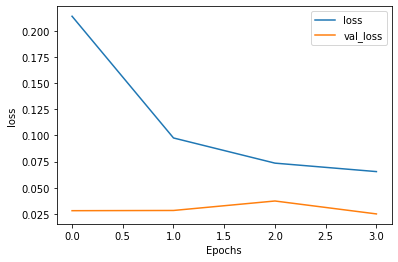

In [ ]:
# Plot training history
plot_graphs(history_us, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18665
           1       0.37      0.81      0.51       107

    accuracy                           0.99     18772
   macro avg       0.68      0.90      0.75     18772
weighted avg       1.00      0.99      0.99     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus}_fps.csv')
print(f"\nThere are {len(table)} 'false' positives ...")

,text,pred,rule_book
1068,"location pipeline services dj basindiesel overflow into secondary containment during restocking process by thirdparty fuel transport company no environmental contact incident 40228thirdparty fuel company hired transport haulertruck to restock fuel tanks at project laydown yard as the transport truck operator was pumping diesel into the storage tank he overflowed approximately fifty thousand, one hundred gallons of diesel into the lined secondarycontainment it is important to note the diesel fuel thatoverflowed by the hauler was fullycontained and the secondary containment was properly remediated by the fuel companynofuel diesel in this case ever touched the soil see detailed description",1,0
12085,a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead spill kits were immediately deployed and the spill was contained on the track near where the welfare unit was located a large plant nappy was also positioned under the welfare units generator and fuel tank the contaminated material from the track was placed on visqueen and will be up lifted and disposed of in line with good environmental practiceno water courses were affected by this incident,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
2005,"water being pumped from underground conduit leaked out of subcontractors vacc truck onto ground approximately twenty gallons work was stopped incident 38211at approximately one thousand, five hundred and thirty a subcontractors vacuum truck was used to vacuum particulate water from underground electrical conduit m1 the vacuum was released to switch over to conduit m2 and it was noticed that water was leaking from the back of the debusk vacuum truck the leak was noticed and stopped immediately resulting in approximately twenty gallons of particulate water being released to the ground the water was sampled for ph and determined to be at six see detailed description",1,0
3677,"adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground incident 34452wpa angore yard adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground the adt was refuelled at 6am this morning approx 40l the adt was parked up in wpa yard and not working where wpa yard what 05lt of diesel to grade when 23th august one thousand, five hundred hrs how fuel tank was over filled which facilitated expansion to occur other refuellers observed spill and cleaned up the machine and contaminated soil further actions refuelling team was stood down and spoke to on importance of not overfilling equipment see detailed description",1,0
9519,small fire on drive pto within ndd truck utilities bay crew members from subcontractor smelled strong odour of burning rubber emanating from services compartment within truck upon opening compartment door saw smoke and small flame escaping pto unit truck shut down immediately crew member used truck compartment dry chemical extinguisher to extinguish flame and cool pto unit rangedale mechanic called to inspect fault is local to pto unit within utilities only truck was operating in carpark area at the time,1,0
65245,inhalation of harmful substancesingle episode an employee was attempting to replace a pressure gauge on a hot gas ammonia line as t


There are 149 'false' positives ...


### Other Methods

#### Cat Boost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import sklearn.model_selection
import sklearn.metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Use Randomsearchcv to find good hyperparameters.
params = {'depth': [5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.1],
 'l2_leaf_reg': [2, 4, 6, 8],
 'iterations': [100, 200, 300, 400]}
cb = CatBoostClassifier()
cb_model = RandomizedSearchCV(cb, params, verbose=1, cv=3, n_jobs=-1)
cb_model.fit(pd.DataFrame(X_train_Glove), y_train.astype(float), verbose=0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4258830e10>,
                   n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7, 8, 9],
                                        'iterations': [100, 200, 300, 400],
                                        'l2_leaf_reg': [2, 4, 6, 8],
                                        'learning_rate': [0.0001, 0.001, 0.005,
                                                          0.01, 0.1]},
                   verbose=1)

In [ ]:
cb_model.best_params_

{'learning_rate': 0.001, 'l2_leaf_reg': 2, 'iterations': 400, 'depth': 6}

In [ ]:
def run_catboost (X, y):
    # split into train and CV data
    n_splits = 5
    splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019).split(X, y))

    models = []
    scores = np.zeros(n_splits)

    print('Training...')

    for i, (idx_train, idx_cv) in enumerate(splits):
        print(f'\nCV Split {i+1} Confusion Matrix:')
        X_train = X.iloc[idx_train, :]
        y_train = y.iloc[idx_train]

        X_cv = X.iloc[idx_cv, :]
        y_cv = y.iloc[idx_cv]

        # Learning rate is important; large values overfit the data
        model = CatBoostClassifier(learning_rate=0.001, depth=6, l2_leaf_reg=2, od_type='IncToDec',
                                loss_function='Logloss', use_best_model=True, eval_metric='MCC')

        model.fit(X_train, y_train.astype(float), silent=True,
                  eval_set=(X_cv, y_cv.astype(float)))

        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)

        score_train = sklearn.metrics.matthews_corrcoef(y_train, y_predict_train)
        score_cv = sklearn.metrics.matthews_corrcoef(y_cv, y_predict_cv)

        models.append(model)
        scores[i] = score_cv

        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('\nRecall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))

        #print('%d %.3f %.3f' % (i, score_train, score_cv))
    
    return(model)
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

In [ ]:
# Train the CatBoost Model on the base data
catboost_model = run_catboost(X=pd.DataFrame(X_train_Glove_us), y=y_train_us)

Training...

CV Split 1 Confusion Matrix:
[[158  30]
 [ 42  52]]

Recall:  0.55
Precision:  0.63

CV Split 2 Confusion Matrix:
[[151  37]
 [ 29  65]]

Recall:  0.69
Precision:  0.64

CV Split 3 Confusion Matrix:
[[164  24]
 [ 46  48]]

Recall:  0.51
Precision:  0.67

CV Split 4 Confusion Matrix:
[[160  28]
 [ 39  55]]

Recall:  0.59
Precision:  0.66

CV Split 5 Confusion Matrix:
[[156  32]
 [ 28  66]]

Recall:  0.7
Precision:  0.67


In [ ]:
y_predict_test = catboost_model.predict(X_test_Glove)
print(Counter(y_test), '\n')
conf_mat_cb = sklearn.metrics.confusion_matrix(y_test, y_predict_test)
false_alarms = round(100*conf_mat_cb[0, 1] / conf_mat_cb[0, 0], 1)
print(conf_mat_cb)
print('\nRecall: ', round(sklearn.metrics.recall_score(y_test, y_predict_test), 2))
print('Precision: ', round(sklearn.metrics.precision_score(y_test, y_predict_test), 2))
print('F beta: ', round(sklearn.metrics.fbeta_score(y_test, y_predict_test, beta=2), 2))
print(f'False Alarms: {false_alarms}%')

Counter({0: 18665, 1: 107}) 

[[15988  2677]
 [   45    62]]

Recall:  0.58
Precision:  0.02
F beta:  0.1
False Alarms: 16.7%


#### Logistic Regression

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_Glove_sc = scaler.fit_transform(X_train_Glove)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_Glove_sc, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_test_Glove, y_test)

0.7802578308118474

In [ ]:
y_predicted = lr_clf.predict(X_test_Glove)

In [ ]:
cnf = metrics.confusion_matrix(y_test, y_predicted)
cnf

array([[14590,  4075],
       [   50,    57]])

In [ ]:
lr_recall = round(cnf[1, 1] / (cnf[1, 0] + cnf[1, 1]), 2)
print(f'Logistic regression recall = {lr_recall}')
lr_prec = round(cnf[1, 1] / (cnf[0, 1] + cnf[1, 1]), 2)
print(f'Logistic regression precision = {lr_prec}')

Logistic regression recall = 0.53
Logistic regression precision = 0.01


#### SVM

In [ ]:
from sklearn.svm import OneClassSVM
# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.005) # 0.5%
svm_model.fit(pd.DataFrame(X_train_Glove))

OneClassSVM(nu=0.005)

In [ ]:
preds_svm = pd.Series(svm_model.predict(X_test_Glove)).map({1: 0, -1: 1})
preds_svm = pd.DataFrame({'prediction':preds_svm})
preds_svm['rule_book'] = y_test.reset_index(drop=True)
preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)]

,prediction,rule_book
1227,1,1
2751,1,1
2829,1,1
6492,1,1
10474,1,1
17640,1,1
17957,1,1


In [ ]:
# Check metrics
svm_ta = len(preds_svm[(preds_svm['rule_book']==1)])
svm_tp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)])
svm_fp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==0)])
svm_pp = len(preds_svm[(preds_svm['prediction']==1)])

prec = svm_tp/svm_pp
reca = svm_tp/svm_ta

print(f'Precision: {round(prec, 2)}')
print(f'Recall: {round(reca, 2)}')

Precision: 0.01
Recall: 0.07
